In [1]:
import pandas as pd
import numpy as np
import re
import keyword
from difflib import get_close_matches
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import statsmodels.formula.api as smf
import scipy.stats as stats
import pylab as pl
import time
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

C:\Users\qguo\AppData\Local\Continuum\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### GOVERNMENT DATA

In [2]:
raw_data = pd.read_csv('https://www.abc.ca.gov/datport/ABC_Data_Export_CSV.zip')

In [3]:
data = raw_data.loc[raw_data['Premise State'] == 'CA', :]
data['Premise Zip'] = data.loc[:,'Premise Zip'].str.slice(0,5)

C:\Users\qguo\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
data.describe()

,License Type,File Number,Duplicate Counts,Term in # of Months,Geo Code,District / Office Code,Premise Census Tract #
count,113663.000000,113663.000000,14654.000000,113663.0,113663.000000,113663.000000,112800.000000
mean,34.729296,461110.286171,1.414358,12.0,2970.206021,15.851931,1825.359968
std,18.029828,123293.466636,7.792846,0.0,1346.948592,9.380925,2306.620328
min,1.000000,4.000000,0.000000,12.0,100.000000,2.000000,0.370000
25%,20.000000,410327.000000,1.000000,12.0,1933.000000,7.000000,85.110000
50%,41.000000,506361.000000,1.000000,12.0,3029.000000,13.000000,525.160000
75%,47.000000,551095.500000,1.000000,12.0,3800.000000,24.000000,3108.000000
max,86.000000,583015.000000,583.000000,12.0,5802.000000,75.000000,9832.000000


In [5]:
data.columns

Index(['License Type', 'File Number', 'License or Application', 'Type Status',
       'Type Original Issue Dates', 'Expiration Dates', 'Fee Codes',
       'Duplicate Counts', 'Master Indicator', 'Term in # of Months',
       'Geo Code', 'District / Office Code', 'Primary Name',
       'Premise Street Address 1', 'Premise Street Address 2', 'Premise City',
       'Premise State', 'Premise Zip', 'DBA Name', 'Mail Street Address 1',
       'Mail Street Address 2', 'Mail City', 'Mail State', 'Mail Zip',
       'Premise County', 'Premise Census Tract #'],
      dtype='object')

In [6]:
data.head()

,License Type,File Number,License or Application,Type Status,Type Original Issue Dates,Expiration Dates,Fee Codes,Duplicate Counts,Master Indicator,Term in # of Months,...,Premise State,Premise Zip,DBA Name,Mail Street Address 1,Mail Street Address 2,Mail City,Mail State,Mail Zip,Premise County,Premise Census Tract #
0,20,100196,LIC,SUREND,21-JAN-1981,30-JUN-2017,P40,NaN,Y,12,...,CA,92201,NaN,NaN,NaN,NaN,NaN,NaN,RIVERSIDE,455.02
1,20,100275,LIC,ACTIVE,18-AUG-1981,31-MAY-2018,P40,NaN,Y,12,...,CA,95822,MILLERS AM PM,NaN,NaN,NaN,NaN,NaN,SACRAMENTO,38.00
2,41,100297,LIC,ACTIVE,09-JUN-1981,31-DEC-2017,P0,NaN,Y,12,...,CA,95448,ROUND TABLE PIZZA,575 W COLLEGE AVE,STE 201,SANTA ROSA,CA,95401,SONOMA,1539.01
3,41,100298,LIC,ACTIVE,05-OCT-1981,31-DEC-2017,P0,NaN,Y,12,...,CA,95453,ROUND TABLE PIZZA,575 W COLLEGE AVE,STE 201,SANTA ROSA,CA,95401,LAKE,4.00
4,9,100306,LIC,ACTIVE,19-MAY-1981,30-JUN-2017,P0,1.0,N,12,...,CA,93514,GILLESPIE DISTRIBUTING COMPANY INC,NaN,NaN,NaN,NaN,NaN,INYO,4.00


In [7]:
#Checking total number of NA rows
data['Premise Street Address 1'].isnull().sum()

0

In [8]:
#Checking total number of NA rows
data['Premise Street Address 2'].isnull().sum()

91968

In [9]:
#Checking number of stores which are not active
len(data.loc[data['Type Status']!='Active'])

113663

In [10]:
data['Type Status'].unique()

array(['SUREND', 'ACTIVE', 'SUSPEN', 'REVPEN', 'PEND', 'R64B', 'SLMSHD'], dtype=object)

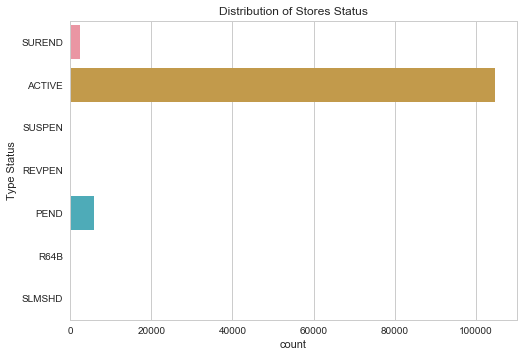

In [11]:
#plot distribution of stores status
plt.title("Distribution of Stores Status")
graph = sns.countplot(y='Type Status', data=data)
graph.set_yticklabels(data['Type Status'].unique(), rotation=0);

In [12]:
len(data['Premise City'].unique())

1324

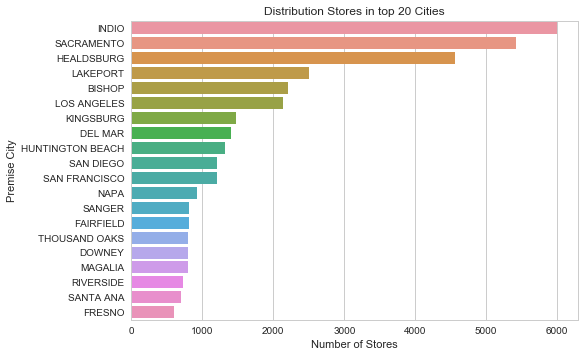

In [13]:
#plot number of stores per city - top 20 cities
plt.title("Distribution Stores in top 20 Cities")
graph = sns.countplot(y='Premise City', data=data, order=data['Premise City'].value_counts().iloc[:20].index)
graph.set_yticklabels(data['Premise City'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Premise City');

In [14]:
len(data['Premise Zip'].unique())

1815

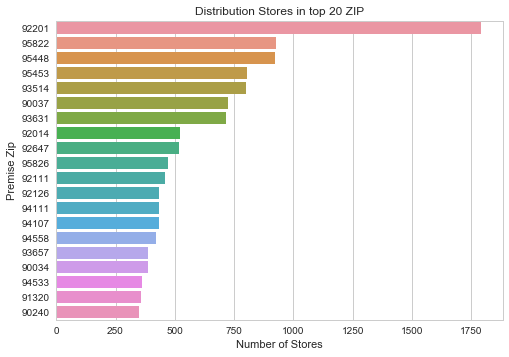

In [15]:
##plot number of stores per zip - top 20 zip
plt.title("Distribution Stores in top 20 ZIP")
graph = sns.countplot(y='Premise Zip', data=data, order=data['Premise Zip'].value_counts().iloc[:20].index)
graph.set_yticklabels(data['Premise Zip'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Premise Zip');

In [16]:
len(data['Premise County'].unique())

58

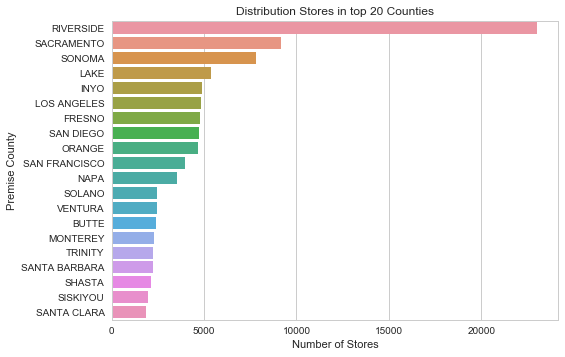

In [17]:
##plot number of stores per county - top 20 counties
plt.title("Distribution Stores in top 20 Counties")
graph = sns.countplot(y='Premise County', data=data, order=data['Premise County'].value_counts().iloc[:20].index)
graph.set_yticklabels(data['Premise County'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Premise County');

In [18]:
len(data['License Type'].unique())

68

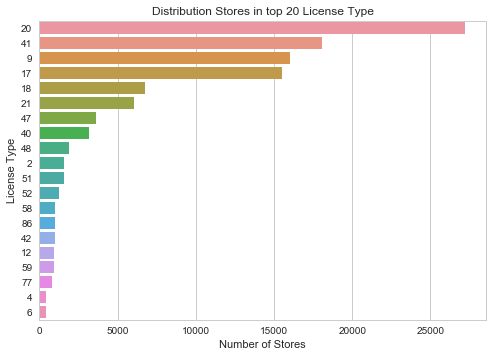

In [19]:
#plot number of stores per license type - top 20 license type
plt.title("Distribution Stores in top 20 License Type")
graph = sns.countplot(y='License Type', data=data, order=data['License Type'].value_counts().iloc[:20].index)
graph.set_yticklabels(data['License Type'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='License Type');

In [20]:
data['Premise Street Address 2'] = data['Premise Street Address 2'].replace(np.nan, '', regex=True)

C:\Users\qguo\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
subsetdata = data.loc[:,['License Type', 'File Number','Primary Name', 'Premise Street Address 1', 'Premise Street Address 2','Premise City','Premise State', 'Premise Zip']]
subsetdata['File Number'] = subsetdata['File Number'].astype(str)
subsetdata.head()

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip
0,20,100196,MEZA ALFREDO T,82675 INDIO BLVD,,INDIO,CA,92201
1,20,100275,D MILLER INC,1391 FLORIN RD,,SACRAMENTO,CA,95822
2,41,100297,WYVERN RESTAURANTS INC,1351 HEALDSBURG AVE,,HEALDSBURG,CA,95448
3,41,100298,WYVERN RESTAURANTS INC,821 11TH ST,,LAKEPORT,CA,95453
4,9,100306,GILLESPIE DISTRIBUTING COMPANY INC,486 E LINE ST,,BISHOP,CA,93514


In [22]:
subsetdata['Full_Address'] = subsetdata['Premise Street Address 1']+ subsetdata['Premise Street Address 2'] +" "+subsetdata['Premise City'] + " " +subsetdata['Premise State']

In [23]:
### Create a Street Column in both tables
subsetdata.loc[subsetdata['Premise Street Address 2']=="",'Full_Address'] = subsetdata['Premise Street Address 1']+ " " +subsetdata['Premise City'] + " " +subsetdata['Premise State']
subsetdata.loc[subsetdata['Premise Street Address 2']!="",'Full_Address'] = subsetdata['Premise Street Address 1']+ " " +subsetdata['Premise Street Address 2']+ " "+subsetdata['Premise City'] + " " +subsetdata['Premise State']

In [24]:
subsetdata=subsetdata.dropna(axis=0,how='any')

### IQ DATA

In [25]:
SQLstoredata = pd.read_csv('DS_CBBD_CA.csv', encoding='utf-8',dtype=str)

In [26]:
SQLstoredata.head()

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,FIPS_COUNTY_DSC,LATITUDE,LONGITUDE
0,107525137,BLAZE PIZZA,201 N PALM CANYON DR,NaN,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,RIVERSIDE,33.825,-116.547
1,107526373,MEIZHOU DONGPO,15363 CULVER DR,NaN,IRVINE,CA,92604,ON PREMISE,OPEN STORE,DINING,ORANGE,33.6947,-117.7981
2,107527101,BERNADETTES BAR,361 S BROADWAY,NaN,LOS ANGELES,CA,90013,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,LOS ANGELES,34.0497,-118.2494
3,105222509,YVES BISTRO,5753 E SANTA ANA CANYON RD STE A,NaN,ANAHEIM,CA,92807,ON PREMISE,OPEN STORE,DINING,ORANGE,33.852,-117.7874
4,102914509,FESTIVAL OF ARTS,650 LAGUNA CANYON RD,NaN,LAGUNA BEACH,CA,92651,ON PREMISE,OPEN STORE,RECREATION,ORANGE,33.548,-117.7821


In [27]:
len(SQLstoredata)

71690

In [28]:
SQLstoredata.isnull().sum()

STORE_CD                0
STORE_DSC               0
ADDR1                   0
ADDR2               71690
CITY                    0
STATE                   0
ZIP5                    0
PREMISE_TYPE_DSC        0
STORE_STTS_DSC          0
CHANNEL_DSC             0
FIPS_COUNTY_DSC         0
LATITUDE                0
LONGITUDE               0
dtype: int64

In [29]:
SQLstoredata['STORE_STTS_DSC'].unique()

array(['OPEN STORE', 'RECLASSIFIED STORE', 'CLOSED STORE', 'FUTURE STORE'], dtype=object)

In [30]:
#check number of stores that are inactive
len(SQLstoredata.loc[SQLstoredata['STORE_STTS_DSC']!='OPEN STORE'])

1236

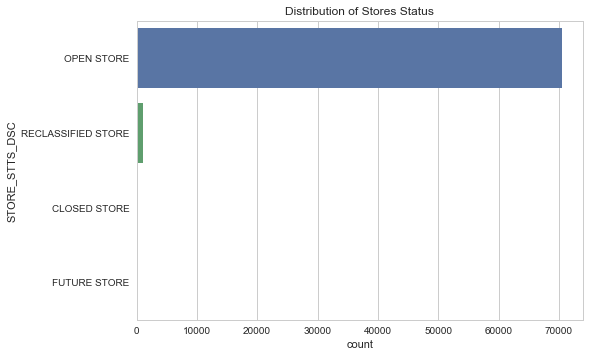

In [31]:
#plot distribution of stores status
plt.title("Distribution of Stores Status")
graph = sns.countplot(y='STORE_STTS_DSC', data=SQLstoredata)
graph.set_yticklabels(SQLstoredata['STORE_STTS_DSC'].unique(), rotation=0);

In [32]:
len(SQLstoredata['CITY'].unique())

1144

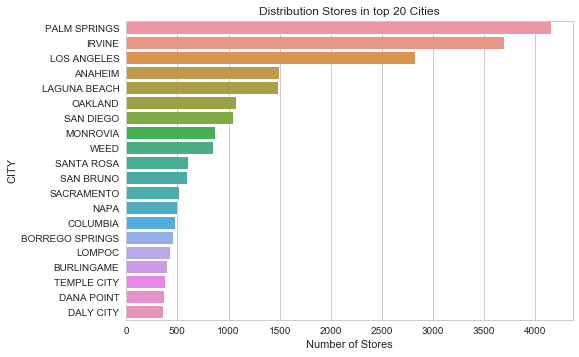

In [33]:
##plot number of stores per city - top 20 cities
plt.title("Distribution Stores in top 20 Cities")
graph = sns.countplot(y='CITY', data=SQLstoredata, order=SQLstoredata['CITY'].value_counts().iloc[:20].index)
graph.set_yticklabels(SQLstoredata['CITY'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='CITY');

In [34]:
len(SQLstoredata['ZIP5'].unique())

1763

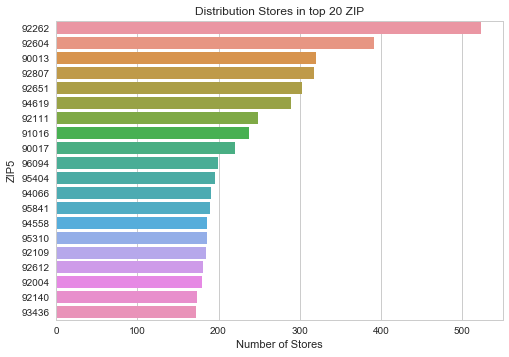

In [35]:
##plot number of stores per zip - top 20 zip
plt.title("Distribution Stores in top 20 ZIP")
graph = sns.countplot(y='ZIP5', data=SQLstoredata, order=SQLstoredata['ZIP5'].value_counts().iloc[:20].index)
graph.set_yticklabels(SQLstoredata['ZIP5'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='ZIP5');

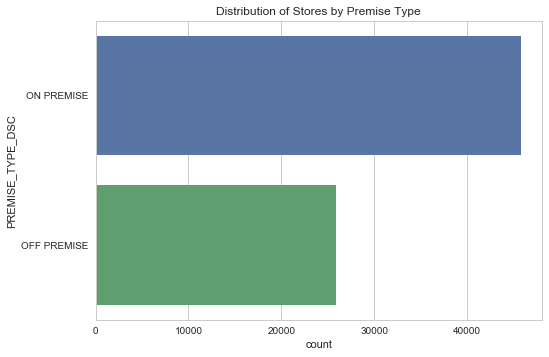

In [36]:
#plot distribution of stores status
plt.title("Distribution of Stores by Premise Type")
graph = sns.countplot(y='PREMISE_TYPE_DSC', data=SQLstoredata)
graph.set_yticklabels(SQLstoredata['PREMISE_TYPE_DSC'].unique(), rotation=0);

In [37]:
SQLstoredata['CHANNEL_DSC'].unique()

array(['DINING', 'BAR/NIGHTCLUB', 'RECREATION', 'CATERER', 'LIQUOR',
       'CONVENIENCE STORE', 'LODGING', 'MILITARY ON-PREMISE',
       'MILITARY OFF-PREMISE', 'TRANSPORTATION', 'GROCERY',
       'MASS MERCHANDISER', 'CIGARETTE OUTLET', 'WHOLESALE CLUB', 'DRUG',
       'EXTENDED MASTER OFF-PREMISE', 'CATEGORY KILLER',
       'EXTENDED MASTER ON-PREMISE'], dtype=object)

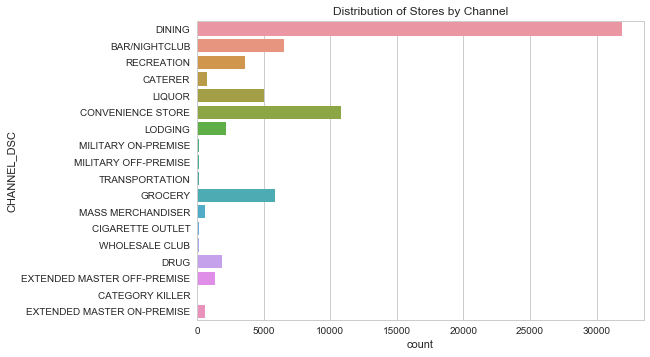

In [38]:
##plot number of stores per channel - top 20 channels
plt.title("Distribution of Stores by Channel")
graph = sns.countplot(y='CHANNEL_DSC', data=SQLstoredata)
graph.set_yticklabels(SQLstoredata['CHANNEL_DSC'].unique(), rotation=0);

In [39]:
len(SQLstoredata['FIPS_COUNTY_DSC'].unique())

58

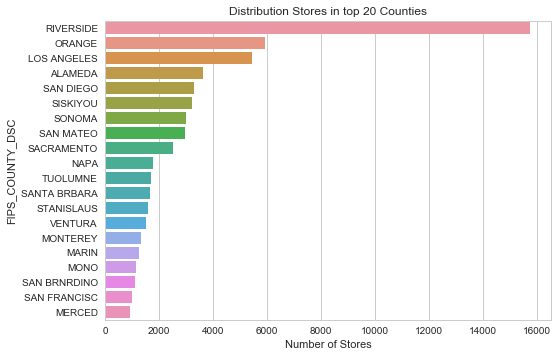

In [40]:
##plot number of stores per counties - top 20 counties
plt.title("Distribution Stores in top 20 Counties")
graph = sns.countplot(y='FIPS_COUNTY_DSC', data=SQLstoredata, order=SQLstoredata['FIPS_COUNTY_DSC'].value_counts().iloc[:20].index)
graph.set_yticklabels(SQLstoredata['FIPS_COUNTY_DSC'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='FIPS_COUNTY_DSC');

### data processing and cleaning

In [41]:
SQLstoredata.head()

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,FIPS_COUNTY_DSC,LATITUDE,LONGITUDE
0,107525137,BLAZE PIZZA,201 N PALM CANYON DR,NaN,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,RIVERSIDE,33.825,-116.547
1,107526373,MEIZHOU DONGPO,15363 CULVER DR,NaN,IRVINE,CA,92604,ON PREMISE,OPEN STORE,DINING,ORANGE,33.6947,-117.7981
2,107527101,BERNADETTES BAR,361 S BROADWAY,NaN,LOS ANGELES,CA,90013,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,LOS ANGELES,34.0497,-118.2494
3,105222509,YVES BISTRO,5753 E SANTA ANA CANYON RD STE A,NaN,ANAHEIM,CA,92807,ON PREMISE,OPEN STORE,DINING,ORANGE,33.852,-117.7874
4,102914509,FESTIVAL OF ARTS,650 LAGUNA CANYON RD,NaN,LAGUNA BEACH,CA,92651,ON PREMISE,OPEN STORE,RECREATION,ORANGE,33.548,-117.7821


In [42]:
SQLstoredata['ADDR2'] = SQLstoredata['ADDR2'].replace(np.nan, '', regex=True)

In [43]:
SQLstoredata['Full_Address'] = SQLstoredata['ADDR1']+ SQLstoredata['ADDR2'] +" "+SQLstoredata['CITY'] + " " +SQLstoredata['STATE']

In [44]:
### Create a Street Column in both tables
SQLstoredata.loc[SQLstoredata['ADDR2']=="",'Full_Address'] = SQLstoredata['ADDR1']+ " " +SQLstoredata['CITY'] + " " +SQLstoredata['STATE']
SQLstoredata.loc[SQLstoredata['ADDR2']!="",'Full_Address'] = SQLstoredata['ADDR1']+ " " +SQLstoredata['ADDR2']+ " "+SQLstoredata['CITY'] + " " +SQLstoredata['STATE']


In [45]:
#create empty data frame
matched_df=pd.DataFrame()
unmatched_df=SQLstoredata

In [46]:
merge_df=pd.merge(unmatched_df,subsetdata,on='Full_Address',how='left')

In [47]:
merge_df.head()

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,...,LONGITUDE,Full_Address,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip
0,107525137,BLAZE PIZZA,201 N PALM CANYON DR,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,...,-116.547,201 N PALM CANYON DR PALM SPRINGS CA,41.0,576984,R&J RESTAURANTS LLC,201 N PALM CANYON DR,,PALM SPRINGS,CA,92262
1,107526373,MEIZHOU DONGPO,15363 CULVER DR,,IRVINE,CA,92604,ON PREMISE,OPEN STORE,DINING,...,-117.7981,15363 CULVER DR IRVINE CA,41.0,577542,AMERICAN MEIZHOU DONGPO IRVINE INC.,15363 CULVER DR,,IRVINE,CA,92604
2,107527101,BERNADETTES BAR,361 S BROADWAY,,LOS ANGELES,CA,90013,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,...,-118.2494,361 S BROADWAY LOS ANGELES CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,105222509,YVES BISTRO,5753 E SANTA ANA CANYON RD STE A,,ANAHEIM,CA,92807,ON PREMISE,OPEN STORE,DINING,...,-117.7874,5753 E SANTA ANA CANYON RD STE A ANAHEIM CA,47.0,377968,YVES BISTRO INC,5753 E SANTA ANA CANYON RD,STE A,ANAHEIM,CA,92807
4,102914509,FESTIVAL OF ARTS,650 LAGUNA CANYON RD,,LAGUNA BEACH,CA,92651,ON PREMISE,OPEN STORE,RECREATION,...,-117.7821,650 LAGUNA CANYON RD LAGUNA BEACH CA,47.0,434646,TIVOLI TERRACE INC,650 LAGUNA CANYON RD,,LAGUNA BEACH,CA,92651


In [48]:
merge_result = merge_df.loc[merge_df['File Number'].isnull() == False]
merge_result.head()

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,...,LONGITUDE,Full_Address,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip
0,107525137,BLAZE PIZZA,201 N PALM CANYON DR,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,...,-116.547,201 N PALM CANYON DR PALM SPRINGS CA,41.0,576984,R&J RESTAURANTS LLC,201 N PALM CANYON DR,,PALM SPRINGS,CA,92262
1,107526373,MEIZHOU DONGPO,15363 CULVER DR,,IRVINE,CA,92604,ON PREMISE,OPEN STORE,DINING,...,-117.7981,15363 CULVER DR IRVINE CA,41.0,577542,AMERICAN MEIZHOU DONGPO IRVINE INC.,15363 CULVER DR,,IRVINE,CA,92604
3,105222509,YVES BISTRO,5753 E SANTA ANA CANYON RD STE A,,ANAHEIM,CA,92807,ON PREMISE,OPEN STORE,DINING,...,-117.7874,5753 E SANTA ANA CANYON RD STE A ANAHEIM CA,47.0,377968,YVES BISTRO INC,5753 E SANTA ANA CANYON RD,STE A,ANAHEIM,CA,92807
4,102914509,FESTIVAL OF ARTS,650 LAGUNA CANYON RD,,LAGUNA BEACH,CA,92651,ON PREMISE,OPEN STORE,RECREATION,...,-117.7821,650 LAGUNA CANYON RD LAGUNA BEACH CA,47.0,434646,TIVOLI TERRACE INC,650 LAGUNA CANYON RD,,LAGUNA BEACH,CA,92651
5,102914509,FESTIVAL OF ARTS,650 LAGUNA CANYON RD,,LAGUNA BEACH,CA,92651,ON PREMISE,OPEN STORE,RECREATION,...,-117.7821,650 LAGUNA CANYON RD LAGUNA BEACH CA,77.0,434646,TIVOLI TERRACE INC,650 LAGUNA CANYON RD,,LAGUNA BEACH,CA,92651


In [49]:
matched_df=merge_result
print('There are', round(len(unmatched_df)/len(SQLstoredata)*100,1), 'percent stores that was unmatched by matching Full_Address')

There are 100.0 percent stores that was unmatched by matching Full_Address


In [50]:
unmatched_df=unmatched_df.loc[-unmatched_df['STORE_CD'].isin(matched_df['STORE_CD']),:]

In [51]:
subsetdata = subsetdata.loc[-subsetdata['File Number'].isin(matched_df['File Number']), :]
subsetdata.head()

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Full_Address
0,20,100196,MEZA ALFREDO T,82675 INDIO BLVD,,INDIO,CA,92201,82675 INDIO BLVD INDIO CA
1,20,100275,D MILLER INC,1391 FLORIN RD,,SACRAMENTO,CA,95822,1391 FLORIN RD SACRAMENTO CA
4,9,100306,GILLESPIE DISTRIBUTING COMPANY INC,486 E LINE ST,,BISHOP,CA,93514,486 E LINE ST BISHOP CA
5,17,100306,GILLESPIE DISTRIBUTING COMPANY INC,486 E LINE ST,,BISHOP,CA,93514,486 E LINE ST BISHOP CA
6,18,100306,GILLESPIE DISTRIBUTING COMPANY INC,486 E LINE ST,,BISHOP,CA,93514,486 E LINE ST BISHOP CA


In [52]:
len(unmatched_df)

20664

In [53]:
len(SQLstoredata)

71690

### Subset by City: NAPA

In [54]:
napa_unmatched_df = unmatched_df.loc[unmatched_df['CITY'] == 'NAPA', :].reset_index(drop = True)
napa_subsetdata = subsetdata.loc[subsetdata['Premise City'] == 'NAPA', :].reset_index(drop = True)
napa_subsetdata.head()

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Full_Address
0,2,101022,MONTICELLO CELLARS INC,4242 BIG RANCH RD,,NAPA,CA,94558,4242 BIG RANCH RD NAPA CA
1,2,110416,SILVERADO VINEYARDS THE,6121 SILVERADO TRL,,NAPA,CA,94558,6121 SILVERADO TRL NAPA CA
2,2,110416,SILVERADO VINEYARDS THE,6121 SILVERADO TRL,,NAPA,CA,94558,6121 SILVERADO TRL NAPA CA
3,6,110416,SILVERADO VINEYARDS THE,6121 SILVERADO TRL,,NAPA,CA,94558,6121 SILVERADO TRL NAPA CA
4,2,129337,OLDS LAWRENCE L,1500 LOKOYA RD,,NAPA,CA,94558,1500 LOKOYA RD NAPA CA


In [55]:
len(napa_unmatched_df)

46

In [56]:
fuzzy_df=napa_unmatched_df
Best_Address=[]

start = time.time()

for address in napa_unmatched_df['Full_Address']:
    address_match_list=get_close_matches(address,list(napa_subsetdata['Full_Address']),n=5,cutoff=0.95)
    Best_Address.append(address_match_list)

end = time.time()    
print(end-start)

0.415600061416626


In [57]:
napa_unmatched_df.loc[0:5, :]

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,FIPS_COUNTY_DSC,LATITUDE,LONGITUDE,Full_Address
0,101608948,NAPA RIVER INN,500 MAIN ST,,NAPA,CA,94559,ON PREMISE,OPEN STORE,LODGING,NAPA,38.2961,-122.2828,500 MAIN ST NAPA CA
1,107318252,SQUARE ONE,1331 1ST ST,,NAPA,CA,94559,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,NAPA,38.2978,-122.288,1331 1ST ST NAPA CA
2,101789187,TR WINES,2545 NAPA VALLEY CORPORATE DR,,NAPA,CA,94558,OFF PREMISE,OPEN STORE,LIQUOR,NAPA,38.2554,-122.2745,2545 NAPA VALLEY CORPORATE DR NAPA CA
3,302219888,TONYS KITCHEN,630 AIRPARK RD,,NAPA,CA,94558,ON PREMISE,OPEN STORE,DINING,NAPA,38.2178,-122.2686,630 AIRPARK RD NAPA CA
4,107338972,STUDIO M FINE WINES,1465 1ST ST,,NAPA,CA,94559,OFF PREMISE,OPEN STORE,LIQUOR,NAPA,38.2973,-122.289,1465 1ST ST NAPA CA
5,103688422,TACOS MICHOACAN,721 LINCOLN AVE,,NAPA,CA,94558,ON PREMISE,OPEN STORE,DINING,NAPA,38.3099,-122.2864,721 LINCOLN AVE NAPA CA


In [58]:
napa_subsetdata.loc[napa_subsetdata['Premise Street Address 1'] == '500 MAIN ST', :]

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Full_Address


In [59]:
Best_Address[0:5]

[[],
 [],
 ['2515 NAPA VALLEY CORPORATE DR NAPA CA',
  '2515 NAPA VALLEY CORPORATE DR NAPA CA',
  '2515 NAPA VALLEY CORPORATE DR NAPA CA',
  '2515 NAPA VALLEY CORPORATE DR NAPA CA',
  '2515 NAPA VALLEY CORPORATE DR NAPA CA'],
 ['620 AIRPARK RD NAPA CA',
  '607 AIRPARK RD NAPA CA',
  '607 AIRPARK RD NAPA CA',
  '607 AIRPARK RD NAPA CA',
  '601 AIRPARK RD NAPA CA'],
 []]

In [60]:
fuzzy_df=napa_unmatched_df
Best_Address=[]

start = time.time()

for address in napa_unmatched_df['Full_Address']:
    address_match_list=get_close_matches(address,list(napa_subsetdata['Full_Address']),n=1,cutoff=0.95)
    Best_Address.append(address_match_list)

end = time.time()    
print(end-start)

0.41249990463256836


In [61]:
Best_Address

[[],
 [],
 ['2515 NAPA VALLEY CORPORATE DR NAPA CA'],
 ['620 AIRPARK RD NAPA CA'],
 [],
 [],
 [],
 [],
 ['1000 MAIN ST STE 150 NAPA CA'],
 [],
 ['2515 NAPA VALLEY CORPORATE DR NAPA CA'],
 [],
 [],
 ['920 FRANKLIN ST NAPA CA'],
 ['2515 NAPA VALLEY CORPORATE DR NAPA CA'],
 ['660  MAIN ST NAPA CA'],
 [],
 [],
 ['3150 B JEFFERSON ST NAPA CA'],
 ['902 ENTERPRISE WAY STE P NAPA CA'],
 ['1203 W. IMOLA AVE. NAPA CA'],
 [],
 ['3150 B JEFFERSON ST NAPA CA'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['3824 BEL AIRE PLAZA NAPA CA'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['2030 REDWOOD RD A NAPA CA'],
 [],
 [],
 [],
 [],
 [],
 []]

In [62]:
unique_city = list(SQLstoredata['CITY'].unique())
unique_city

['PALM SPRINGS',
 'IRVINE',
 'LOS ANGELES',
 'ANAHEIM',
 'LAGUNA BEACH',
 'OAKLAND',
 'SAN DIEGO',
 'MONROVIA',
 'WEED',
 'SANTA ROSA',
 'SAN BRUNO',
 'SACRAMENTO',
 'NAPA',
 'COLUMBIA',
 'BORREGO SPRINGS',
 'LOMPOC',
 'BURLINGAME',
 'TEMPLE CITY',
 'DANA POINT',
 'DALY CITY',
 'MODESTO',
 'THOUSAND OAKS',
 'PEBBLE BEACH',
 'SAN RAFAEL',
 'CYPRESS',
 'GLENDALE',
 'BRIDGEPORT',
 'PASADENA',
 'MALIBU',
 'GARDEN GROVE',
 'EL CAJON',
 'BUENA PARK',
 'REDLANDS',
 'SAN FRANCISCO',
 'SAN BERNARDINO',
 'MERCED',
 'PISMO BEACH',
 'RIVERSIDE',
 'GARDENA',
 'SANTA MONICA',
 'ROSEMEAD',
 'HUNTINGTON BEACH',
 'BELL',
 'FRESNO',
 'SAN LUIS OBISPO',
 'CITRUS HEIGHTS',
 'HAYWARD',
 'GRAND TERRACE',
 'INGLEWOOD',
 'WEST HOLLYWOOD',
 'EL CENTRO',
 'PLEASANT HILL',
 'SANTA ANA',
 'VENTURA',
 'ORANGE',
 'SAN CLEMENTE',
 'CONCORD',
 'BERKELEY',
 'MURRIETA',
 'EL MONTE',
 'SAN JUAN CAPISTRANO',
 'SIMI VALLEY',
 'FONTANA',
 'LONG BEACH',
 'ALAMEDA',
 'CERRITOS',
 'SAN JOSE',
 'OXNARD',
 'HARBOR CITY',
 'WINN

In [93]:
modify_city=[]

for city in subsetdata['Premise City']:
    city_match_list=get_close_matches(city, unique_city, n=1, cutoff=0.90)
    modify_city.append(city_match_list)
    
modify_city

[['INDIO'],
 ['SACRAMENTO'],
 ['BISHOP'],
 ['BISHOP'],
 ['BISHOP'],
 ['NAPA'],
 ['LOS ANGELES'],
 ['THOUSAND OAKS'],
 ['CHICO'],
 ['HAYFORK'],
 ['SANTA MARIA'],
 ['FRESNO'],
 ['WEED'],
 ['LOWER LAKE'],
 ['SANTA CRUZ'],
 ['SANTA CRUZ'],
 ['VISALIA'],
 ['VISALIA'],
 ['EL MONTE'],
 ['MOUNT LAGUNA'],
 ['KING CITY'],
 ['WILMINGTON'],
 ['SANTA FE SPRINGS'],
 ['RIVERBANK'],
 ['RIVERBANK'],
 ['LOS ANGELES'],
 ['LOS ANGELES'],
 ['LOS ANGELES'],
 ['PLANADA'],
 ['REDWOOD CITY'],
 ['SANTA FE SPRINGS'],
 ['MANTECA'],
 ['MANTECA'],
 ['MANTECA'],
 ['MANTECA'],
 ['MANTECA'],
 ['MANTECA'],
 ['SAN FRANCISCO'],
 ['LA PUENTE'],
 ['LA PUENTE'],
 [],
 ['HAYWARD'],
 ['HAYWARD'],
 [],
 [],
 ['DUNCANS MILLS'],
 ['SAN JOSE'],
 ['STOCKTON'],
 ['LOS ANGELES'],
 ['LOS ANGELES'],
 ['LOS ANGELES'],
 ['LOS ANGELES'],
 ['STOCKTON'],
 ['SAINT HELENA'],
 ['SAINT HELENA'],
 ['SAINT HELENA'],
 ['SAINT HELENA'],
 [],
 ['LAKE ARROWHEAD'],
 ['LAKE ARROWHEAD'],
 ['MARKLEEVILLE'],
 ['SANTA MARGARITA'],
 ['SANTA MARGARITA'],
 [

In [94]:
new_city = []
for l in modify_city:
    if len(l) > 0:
        new_city.append(l[0])
    else:
        new_city.append(' ')
new_city

['INDIO',
 'SACRAMENTO',
 'BISHOP',
 'BISHOP',
 'BISHOP',
 'NAPA',
 'LOS ANGELES',
 'THOUSAND OAKS',
 'CHICO',
 'HAYFORK',
 'SANTA MARIA',
 'FRESNO',
 'WEED',
 'LOWER LAKE',
 'SANTA CRUZ',
 'SANTA CRUZ',
 'VISALIA',
 'VISALIA',
 'EL MONTE',
 'MOUNT LAGUNA',
 'KING CITY',
 'WILMINGTON',
 'SANTA FE SPRINGS',
 'RIVERBANK',
 'RIVERBANK',
 'LOS ANGELES',
 'LOS ANGELES',
 'LOS ANGELES',
 'PLANADA',
 'REDWOOD CITY',
 'SANTA FE SPRINGS',
 'MANTECA',
 'MANTECA',
 'MANTECA',
 'MANTECA',
 'MANTECA',
 'MANTECA',
 'SAN FRANCISCO',
 'LA PUENTE',
 'LA PUENTE',
 ' ',
 'HAYWARD',
 'HAYWARD',
 ' ',
 ' ',
 'DUNCANS MILLS',
 'SAN JOSE',
 'STOCKTON',
 'LOS ANGELES',
 'LOS ANGELES',
 'LOS ANGELES',
 'LOS ANGELES',
 'STOCKTON',
 'SAINT HELENA',
 'SAINT HELENA',
 'SAINT HELENA',
 'SAINT HELENA',
 ' ',
 'LAKE ARROWHEAD',
 'LAKE ARROWHEAD',
 'MARKLEEVILLE',
 'SANTA MARGARITA',
 'SANTA MARGARITA',
 'SANTA MARGARITA',
 'SANTA MARGARITA',
 'FORESTHILL',
 'FONTANA',
 'WINDSOR',
 'SAN FRANCISCO',
 'LONG BEACH',
 'LO

In [95]:
subsetdata['MODIFY CITY'] = new_city
subsetdata['isChange'] = subsetdata['MODIFY CITY'] != subsetdata['Premise City']

In [96]:
subsetdata.head()

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Full_Address,MODIFY CITY,isChange
0,20,100196,MEZA ALFREDO T,82675 INDIO BLVD,,INDIO,CA,92201,82675 INDIO BLVD INDIO CA,INDIO,False
1,20,100275,D MILLER INC,1391 FLORIN RD,,SACRAMENTO,CA,95822,1391 FLORIN RD SACRAMENTO CA,SACRAMENTO,False
4,9,100306,GILLESPIE DISTRIBUTING COMPANY INC,486 E LINE ST,,BISHOP,CA,93514,486 E LINE ST BISHOP CA,BISHOP,False
5,17,100306,GILLESPIE DISTRIBUTING COMPANY INC,486 E LINE ST,,BISHOP,CA,93514,486 E LINE ST BISHOP CA,BISHOP,False
6,18,100306,GILLESPIE DISTRIBUTING COMPANY INC,486 E LINE ST,,BISHOP,CA,93514,486 E LINE ST BISHOP CA,BISHOP,False


In [97]:
tempDF = subsetdata.loc[subsetdata['isChange'] == True, :]
tempDF

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Full_Address,MODIFY CITY,isChange
125,52,105803,AMERICAN LEGION ORCUTT POST 534,145 W CLARK AVE,,ORCUTT,CA,93455,145 W CLARK AVE ORCUTT CA,,True
133,52,106122,VFW QUARTZ HILL POST 3000,4342 W AVENUE L,,QUARTZ HILL,CA,93536,4342 W AVENUE L QUARTZ HILL CA,,True
134,58,106122,VFW QUARTZ HILL POST 3000,4342 W AVENUE L,,QUARTZ HILL,CA,93536,4342 W AVENUE L QUARTZ HILL CA,,True
154,41,107069,SAVKO EDWARD J,30350 MULHOLLAND HWY,,CORNELL,CA,91301,30350 MULHOLLAND HWY CORNELL CA,,True
190,20,108854,CASELLA GARY J,442 PENINSULA DR LAKE ALMANOR PEN,,LAKE ALMANOR,CA,96137,442 PENINSULA DR LAKE ALMANOR PEN LAKE ALMANOR CA,,True
210,49,109488,GRAEAGLE LAND & WATER CO INC,6934 HIGHWAY 89,,GRAEAGLE,CA,96103,6934 HIGHWAY 89 GRAEAGLE CA,,True
211,49,109488,GRAEAGLE LAND & WATER CO INC,6934 HIGHWAY 89,,GRAEAGLE,CA,96103,6934 HIGHWAY 89 GRAEAGLE CA,,True
329,21,112883,STATER BROS MARKETS,5571 MISSION BLVD,,JURUPA VALLEY,CA,92509,5571 MISSION BLVD JURUPA VALLEY CA,,True
337,21,112895,STATER BROS MARKETS,9155 JURUPA RD,,JURUPA VALLEY,CA,92509,9155 JURUPA RD JURUPA VALLEY CA,,True
341,21,112902,STATER BROS MARKETS,11070 LIMONITE AVE,,JURUPA VALLEY,CA,91752,11070 LIMONITE AVE JURUPA VALLEY CA,,True


In [98]:
tempDF.loc[tempDF['MODIFY CITY'] != ' ', :]

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Full_Address,MODIFY CITY,isChange
7465,41,280361,SAHAGUN GLORIA,260 SAN PEDRO RD,,COLMA,CA,94014,260 SAN PEDRO RD COLMA CA,COLOMA,True
8473,21,293453,ALZGOUL OMAR MOHAMMAD HAMDI,1165 HILLSIDE BLVD,,COLMA,CA,94014,1165 HILLSIDE BLVD COLMA CA,COLOMA,True
23036,21,395490,TARGET CORPORATION,5001 JUNIPERO SERRA BLVD,,COLMA,CA,94014,5001 JUNIPERO SERRA BLVD COLMA CA,COLOMA,True
29653,47,422627,DAVID BONNIE,5417 MAIN ST,,BLAIRSDEN-GRAEAGLE,CA,96103,5417 MAIN ST BLAIRSDEN-GRAEAGLE CA,BLAIRSDEN GRAEAGLE,True
31532,41,429308,MOUNTAIN HIGH RESORT ASSOCIATES LLC,1 TABLE MTN RD,,BIG PINES,CA,93563,1 TABLE MTN RD BIG PINES CA,BIG PINE,True
31533,41,429308,MOUNTAIN HIGH RESORT ASSOCIATES LLC,1 TABLE MTN RD,,BIG PINES,CA,93563,1 TABLE MTN RD BIG PINES CA,BIG PINE,True
31546,47,429343,MOUNTAIN HIGH RESORT ASSOCIATES LLC,24512 STATE HWY 2,ANGELES CREST CAFE EAST MAIN,BIG PINES,CA,93563,24512 STATE HWY 2 ANGELES CREST CAFE EAST MAIN...,BIG PINE,True
31547,47,429343,MOUNTAIN HIGH RESORT ASSOCIATES LLC,24512 STATE HWY 2,ANGELES CREST CAFE EAST MAIN,BIG PINES,CA,93563,24512 STATE HWY 2 ANGELES CREST CAFE EAST MAIN...,BIG PINE,True
31548,77,429343,MOUNTAIN HIGH RESORT ASSOCIATES LLC,24512 STATE HWY 2,ANGELES CREST CAFE EAST MAIN,BIG PINES,CA,93563,24512 STATE HWY 2 ANGELES CREST CAFE EAST MAIN...,BIG PINE,True
31549,77,429343,MOUNTAIN HIGH RESORT ASSOCIATES LLC,24512 STATE HWY 2,ANGELES CREST CAFE EAST MAIN,BIG PINES,CA,93563,24512 STATE HWY 2 ANGELES CREST CAFE EAST MAIN...,BIG PINE,True


In [100]:
tempDF.loc[tempDF['MODIFY CITY'] != ' ', 'MODIFY CITY'].unique()

array(['COLOMA', 'BLAIRSDEN GRAEAGLE', 'BIG PINE', 'SMARTSVILLE'], dtype=object)